In [3]:
import torch, utils, math
from torch import nn

def masked_softmax(X, valid_lens=None):
    """
    带遮蔽的softmax函数, 通过在最后一个轴上遮蔽元素来执行softmax操作\n
    参数:\n
        X : 3D张量\n
        valid_lenss : 1D或2D张量\n
    """
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = utils.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# masked_softmax函数的测试
# 考虑由两个2 × 4矩阵表示的样本, 这两个样本的有效长度分别为2和3, 经过掩蔽softmax操作, 超出有效长度的值都被掩蔽为0。
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))) # 1D valid_lens
# 使用二维张量, 为矩阵样本中的每一行指定有效长度。
print(masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))) # 2D valid_lens

tensor([[[0.6753, 0.3247, 0.0000, 0.0000],
         [0.4137, 0.5863, 0.0000, 0.0000]],

        [[0.4116, 0.2798, 0.3087, 0.0000],
         [0.4459, 0.2999, 0.2543, 0.0000]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3569, 0.3222, 0.3209, 0.0000]],

        [[0.4589, 0.5411, 0.0000, 0.0000],
         [0.3991, 0.1787, 0.2362, 0.1860]]])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)


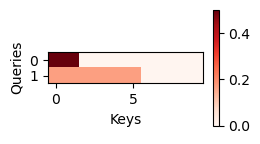

In [4]:
# 加性注意力
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，queries的形状:(batch_size，查询的个数，1，num_hidden)
        # key的形状:(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1) # 求和后shape:(batch_size,查询的个数，“键-值”对的个数，num_hiddens)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        scores = self.w_v(features).squeeze(-1) # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        self.attention_weights = masked_softmax(scores, valid_lens) # --> 形状：(batch_size, 查询个数, “键－值”对的个数)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
print(attention(queries, keys, values, valid_lens))

# 尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，所以注意力权重是均匀的，由指定的有效长度决定。
utils.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

### 加性注意力
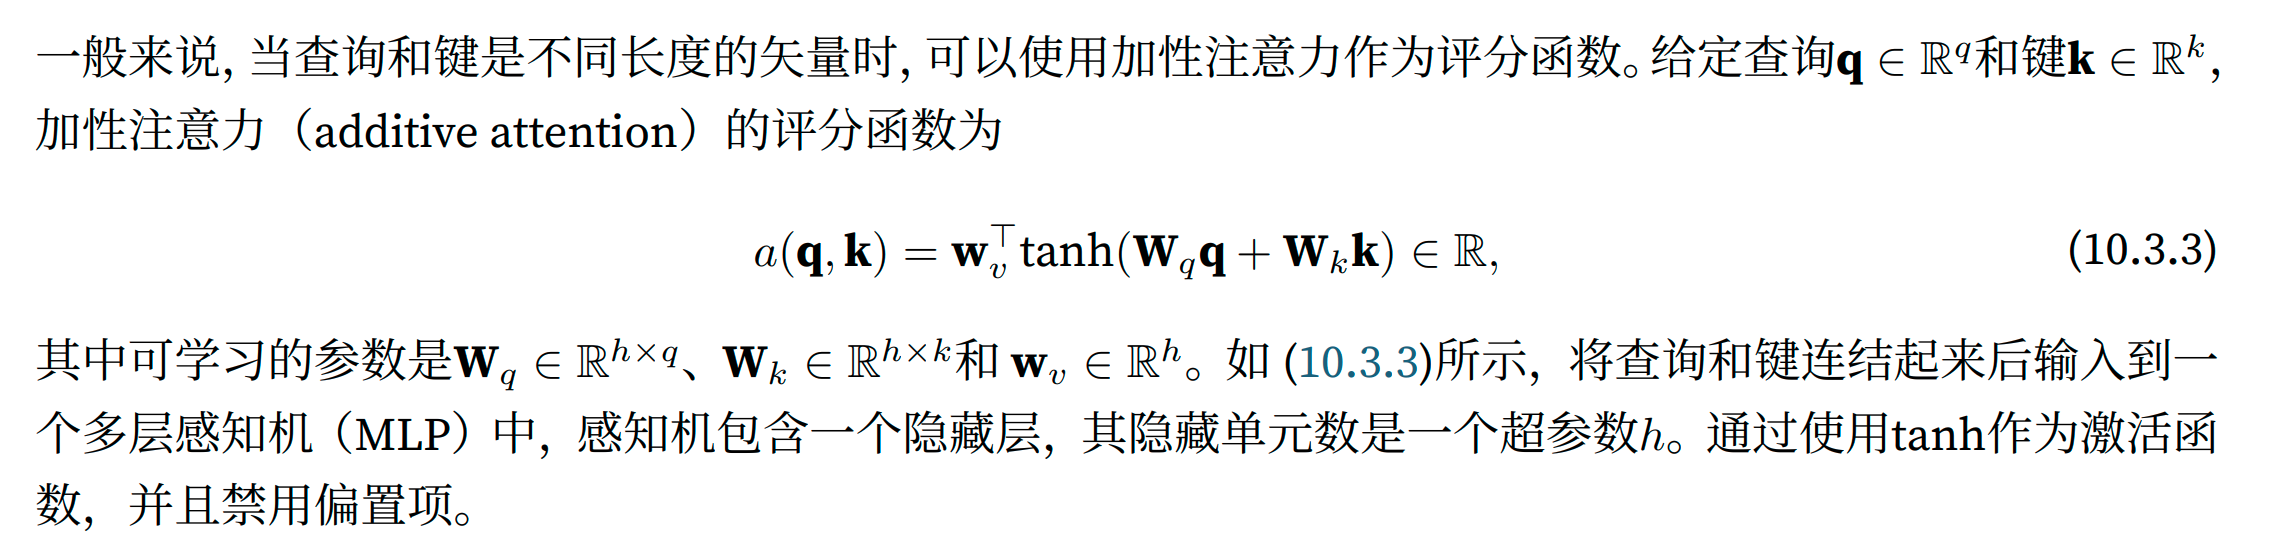

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])


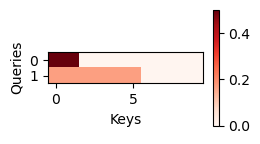

In [5]:
# 缩放点积注意力
class ScaledDotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

queries = torch.normal(0, 1, (2, 1, 2))
attention = ScaledDotProductAttention(dropout=0.5)
attention.eval()
print(attention(queries, keys, values, valid_lens))

# 与加性注意力演示相同，由于键包含的是相同的元素，而这些元素无法通过任何查询进行区分，因此获得了均匀的注意力权重。
utils.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

### 缩放点积注意力
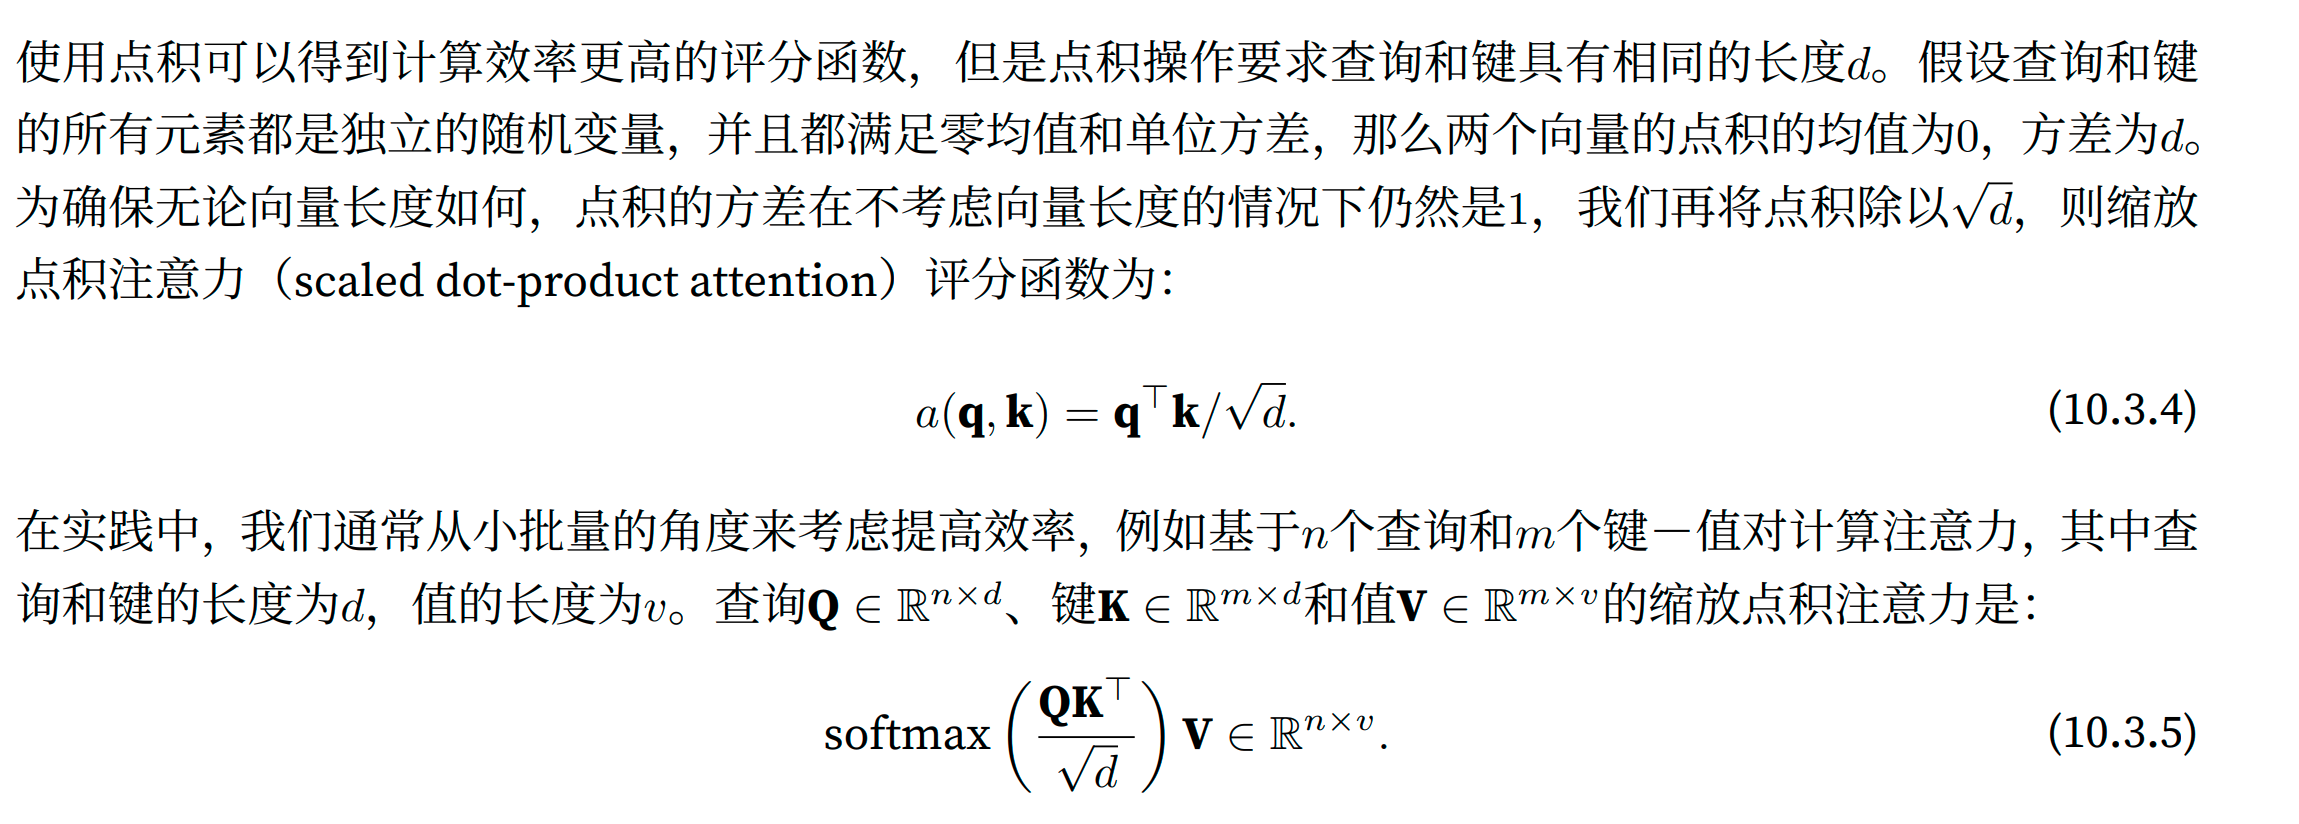

### 加性注意力和缩放点积注意力的区别
相同长度$d$是$q$的特征维度等于$k$的特征维度。因为点积需要对应维度相同。这里是需要$q$的特征维度等于k的特征维度才能得到对应的未一化相关系数。<br>
加性注意力因为$q$与$k$特征维度不等，所以用$W_q$和$W_k$将他们的维度放缩到同一个维度，然后使用广播机制让同一个$q$与每个$k$相加，然后使用共享的$W_v$来将他们点积得到一个标量，也就是相关系数。<br>
也就是说，缩放点积直接通过点积得到注意力分数，没有任何的学习参数。而加性注意力是通过可学习参数先进行放缩，然后进行$q$与$k$的特征相加。<br>
区别在于：①是否可学习 ②特征进行点积还是特征进行相加